In [1]:
import os
os.chdir('C://Users/Doudou/python learning/Python Engineer/Machine learning from scratch')

import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris


from collections import Counter
import pydot
import graphviz

### Decision tree regressor
- Outcome is continuous
- split criteria: MSE

### Decision tree classifier
- Outcome is categorical
- split criteria: Gini or information gain (caculated by Entropy)

### This learning note will introduce decision tree classifier

### Algorithm 

#### Two methods to select best split criteria for root node

##### Gini impurity (CART)

$Gini=1-\sum_{n=0}^{j}P(i)^2$

![SNOWFALL](impurity_png.png) 
                         


Gini for left node:$1-((\dfrac{105}{105+39})^2+(\dfrac{39}{105+39})^2)$=0.395

Gini for right node:$1-((\dfrac{34}{34+125})^2+(\dfrac{125}{34+125})^2)$=0.336

Gini for parent node(Chest Pain): weighted averge of Gini for the children nodes

$=(\dfrac{144}{144+159})*0.395+(\dfrac{159}{144+159})*0.336)=0.364$

The less the Gini index is, the better criteria to split the parent node. Range from 0 to 0.5.

#####  Entropy and Infomation gain (ID3)

Entropy: $-\sum_{n=0}^{j}P(i)*(log_2(P(i))$

Entropy for parent nodes: $-((\dfrac{144}{144+159}*log_2(\dfrac{144}{144+159})+(\dfrac{159}{144+159}*log_2(\dfrac{159}{144+159}))=1.0$

Entropy for left nodes: $-((\dfrac{105}{105+39}*log_2(\dfrac{105}{105+39})+(\dfrac{39}{105+39}*log_2(\dfrac{39}{105+39}))=0.84$

Entropy for right nodes: $-((\dfrac{34}{34+125}*log_2(\dfrac{34}{34+125})+(\dfrac{125}{34+125}*log_2(\dfrac{125}{34+125}))=0.75$

Average child entropy: $(\dfrac{144}{144+159})*0.84+(\dfrac{159}{144+159})*0.75)=0.79$

Infomation gain: $Parent Entropy-Average child entropy=1.0-0.79=0.21$

The greater the information gain, the better criteria to split the parent node. Range from 0 to 1.

<font size='1'>Plot source from https://pandulaofficial.medium.com/implementing-cart-algorithm-from-scratch-in-python-5dd00e9d36e</font>


## Prepare the dataset 

In [2]:
data = load_iris()
DataX=data.data
Datay=data.target
X_train, X_test, y_train,y_test=train_test_split(DataX,Datay, test_size=0.2,random_state=1234)
classes, counts = np.unique(y_train, return_counts=True)
print(X_train.shape)
print(classes)
print(counts)

(120, 4)
[0 1 2]
[41 37 42]


In [3]:
X_train[:10]

array([[5.1, 2.5, 3. , 1.1],
       [6.2, 2.8, 4.8, 1.8],
       [5. , 3.5, 1.3, 0.3],
       [6.3, 2.8, 5.1, 1.5],
       [6.7, 3. , 5. , 1.7],
       [4.8, 3.4, 1.9, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [5.4, 3.4, 1.7, 0.2],
       [4.6, 3.6, 1. , 0.2],
       [5. , 2.3, 3.3, 1. ]])

### An example of gini caculation

In [4]:
X=X_train
y=y_train
classes, counts = np.unique(y, return_counts=True)
probabilities = counts / len(y)
gini=1 - np.sum(probabilities ** 2)
print(f"probabilities:{probabilities}")
print(f"gini:{gini}")

probabilities:[0.34166667 0.30833333 0.35      ]
gini:0.6656944444444444


In [5]:
def gini_impurity(y):
    classes, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    gini = 1 - np.sum(probabilities ** 2)
    return gini

In [6]:
gini=gini_impurity(y)
print(gini)

0.6656944444444444


### A split

In [7]:
n_samples, n_features = X.shape
feature=0
threshold=5.1
left_mask = X[:, feature] <=threshold
right_mask = ~left_mask
left_y=y[left_mask]
right_y=y[right_mask]
left_gini=gini_impurity(left_y)
right_gini=gini_impurity(right_y)
gini=(np.sum(left_mask)*left_gini+np.sum(right_mask)*right_gini)/n_samples
print(f"gini:{gini}")

gini:0.5073415412676698


In [8]:
gini = (np.sum(left_mask) * gini_impurity(y[left_mask]) +
          np.sum(right_mask) * gini_impurity(y[right_mask])) / n_samples
print(f"gini:{gini}")

gini:0.5073415412676698


### Greedy search for best split

In [9]:
n_samples, n_features = X.shape
thresholds = np.unique(X[:, feature])
best_gini = float('inf')
best_feature = None
best_threshold = None
for threshold in thresholds:
    left_mask = X[:, feature] <= threshold
    right_mask = ~left_mask

    gini = (np.sum(left_mask) * gini_impurity(y[left_mask]) +
            np.sum(right_mask) * gini_impurity(y[right_mask])) / n_samples
    if gini < best_gini:
        best_gini = gini
        best_feature = feature
        best_threshold = threshold

print(best_threshold)

5.4


In [10]:
for feature in range(n_features):
    thresholds = np.unique(X[:, feature])

    for threshold in thresholds:
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        gini = (np.sum(left_mask) * gini_impurity(y[left_mask]) +
                np.sum(right_mask) * gini_impurity(y[right_mask])) / n_samples

        if gini < best_gini:
            best_gini = gini
            best_feature = feature
            best_threshold = threshold
print(f"best_feature:{best_feature}")
print(f"best_threshold:{best_threshold}")

best_feature:2
best_threshold:1.9


In [11]:
def best_split(X, y):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                gini = (np.sum(left_mask) * gini_impurity(y[left_mask]) +
                        np.sum(right_mask) * gini_impurity(y[right_mask])) / n_samples
                
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

In [12]:
best_feature, best_threshold=best_split(X, y)
print(f"best_feature:{best_feature}")
print(f"best_threshold:{best_threshold}")

best_feature:2
best_threshold:1.9


In [13]:
#split data with best split (an example to identify majority class)
n_samples, n_features = X.shape
feature=2
threshold=1.9
left_mask = X[:, feature] <= threshold
right_mask = ~left_mask
left_y=y[left_mask]
right_y=y[right_mask]


In [14]:
classes, counts = np.unique(y[left_mask], return_counts=True)
majority_class = classes[np.argmax(counts)]
print(classes)
print(counts)
print(majority_class)

[0]
[41]
0


In [15]:
classes, counts = np.unique(y[right_mask], return_counts=True)
majority_class = classes[np.argmax(counts)]
print(classes)
print(counts)
print(majority_class)

[1 2]
[37 42]
2


In [16]:
def majority_class(y):
    classes, counts = np.unique(y, return_counts=True)
    majority_class = classes[np.argmax(counts)]
    return majority_class

In [17]:
class_left=majority_class(y[left_mask])
class_right=majority_class(y[right_mask])
print(f"class_left:{class_left}")
print(f"class_right:{class_right}")

class_left:0
class_right:2


### Build tree

Python recursion function

In [18]:
max_depth=3
def grow_tree(X, y, depth=0):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)
        gini=round(gini_impurity(y),2)
        
        # Check for stopping criteria
        if len(unique_classes) == 1:
            return {'feature': None, 'threshold':  None,'gini': gini,
                'left':  None, 'right':  None,'class': unique_classes[0],'is_node':1 }

        if max_depth is not None and depth == max_depth:
            return {'feature': None, 'threshold':  None,'gini': gini,
                'left':  None, 'right':  None,'class': majority_class(y),'is_node':1 }


        # Find the best split
        feature, threshold = best_split(X, y)

        # Split the data
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left_tree = grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = grow_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature': feature, 'threshold': threshold,'gini':gini,
                'left': left_tree, 'right': right_tree,'class':None,'is_node':None}

In [19]:
trees=grow_tree(X, y)
print(trees)

{'feature': 2, 'threshold': 1.9, 'gini': 0.67, 'left': {'feature': None, 'threshold': None, 'gini': 0.0, 'left': None, 'right': None, 'class': 0, 'is_node': 1}, 'right': {'feature': 3, 'threshold': 1.7, 'gini': 0.5, 'left': {'feature': 2, 'threshold': 4.9, 'gini': 0.21, 'left': {'feature': None, 'threshold': None, 'gini': 0.06, 'left': None, 'right': None, 'class': 1, 'is_node': 1}, 'right': {'feature': None, 'threshold': None, 'gini': 0.44, 'left': None, 'right': None, 'class': 2, 'is_node': 1}, 'class': None, 'is_node': None}, 'right': {'feature': 2, 'threshold': 4.8, 'gini': 0.05, 'left': {'feature': None, 'threshold': None, 'gini': 0.44, 'left': None, 'right': None, 'class': 2, 'is_node': 1}, 'right': {'feature': None, 'threshold': None, 'gini': 0.0, 'left': None, 'right': None, 'class': 2, 'is_node': 1}, 'class': None, 'is_node': None}, 'class': None, 'is_node': None}, 'class': None, 'is_node': None}


In [20]:
def print_decision_tree(node, prefix="", is_last=True):
    print(prefix + ("`-- " if is_last else "|-- ") + f"Feature: {node['feature']}, Threshold: {node['threshold']}, Gini: {node['gini']},Class:{node['class']},node:{node['is_node']}")
    
    prefix += "    " if is_last else "|   "
    
    if 'left' in node and node['left'] is not None:
        print_decision_tree(node['left'], prefix, False)
    
    if 'right' in node and node['right'] is not None:
        print_decision_tree(node['right'], prefix, True)
        
print_decision_tree(trees)

`-- Feature: 2, Threshold: 1.9, Gini: 0.67,Class:None,node:None
    |-- Feature: None, Threshold: None, Gini: 0.0,Class:0,node:1
    `-- Feature: 3, Threshold: 1.7, Gini: 0.5,Class:None,node:None
        |-- Feature: 2, Threshold: 4.9, Gini: 0.21,Class:None,node:None
        |   |-- Feature: None, Threshold: None, Gini: 0.06,Class:1,node:1
        |   `-- Feature: None, Threshold: None, Gini: 0.44,Class:2,node:1
        `-- Feature: 2, Threshold: 4.8, Gini: 0.05,Class:None,node:None
            |-- Feature: None, Threshold: None, Gini: 0.44,Class:2,node:1
            `-- Feature: None, Threshold: None, Gini: 0.0,Class:2,node:1


In [24]:
def export_tree_to_dot(node,dot, parent_node_id=None):
    node_id =id(node)
    feature=node['feature']
    threshold=node['threshold']
    gini=node['gini']
    label = f"feature:{feature} \n x<={threshold} \n gini:{gini}"

    if node['is_node']==1:
        t=node['class']
        label = f"class:{t} \n"
        dot.add_node(pydot.Node(node_id, label=label,shape='square',style='filled',fillcolor='green'))
            
    dot.add_node(pydot.Node(node_id, label=label,shape='square'))
    
    if parent_node_id:
        dot.add_edge(pydot.Edge(parent_node_id, node_id))

    if node['threshold'] is not None:
        export_tree_to_dot(node['left'], dot, parent_node_id=node_id)
        export_tree_to_dot(node['right'], dot, parent_node_id=node_id)

In [22]:
dot = pydot.Dot('my_graph', graph_type='graph') 
export_tree_to_dot(trees, dot, parent_node_id=None)
g=graphviz.Source(dot, format='png')
g.render("test_basic_gini",view=True)

'test_basic_gini.png'

![SNOWFALL](test_basic_gini.png) 

In [22]:
def predict_tree(x, node):
        if node['is_node']==1:
            return node['class']
        else:
            if x[node['feature']] <= node['threshold']:
                return predict_tree(x, node['left'])
            else:
                return predict_tree(x, node['right'])

In [23]:
x0=X_test[0]
print(x0)
cls=predict_tree(x0, trees)
print(f"predicted class for x0:{cls}")

[6.1 3.  4.6 1.4]
predicted class for x0:1


In [24]:
y_pred=np.array([predict_tree(x, trees) for x in X_test])
print(y_pred.shape)

(30,)


In [25]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 1.0000


In [22]:
class DecisionTree_gini:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)
        gini=round(self._gini_impurity(y),2)
        # Check for stopping criteria
        if len(unique_classes) == 1:
            return {'feature': None, 'threshold':  None,'gini': gini,
                'left':  None, 'right':  None,'class': unique_classes[0],'is_node':1 }

        if self.max_depth is not None and depth == self.max_depth:
            return {'feature': None, 'threshold':  None,'gini': gini,
                'left':  None, 'right':  None,'class': self._majority_class(y),'is_node':1 }


        # Find the best split
        feature, threshold = self._best_split(X, y)

        # Split the data
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left_tree = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_tree = self._grow_tree(X[right_mask], y[right_mask], depth + 1)

        return {'feature': feature, 'threshold': threshold,'gini':gini,
                'left': left_tree, 'right': right_tree,'class':None,'is_node':None}

    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)

        best_gini = float('inf')
        best_feature = None
        best_threshold = None

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                gini = (np.sum(left_mask) * self._gini_impurity(y[left_mask]) +
                        np.sum(right_mask) * self._gini_impurity(y[right_mask])) / n_samples
                
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _gini_impurity(self, y):
        classes, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        gini = 1 - np.sum(probabilities ** 2)
        return gini

    def _majority_class(self, y):
        classes, counts = np.unique(y, return_counts=True)
        majority_class = classes[np.argmax(counts)]
        return majority_class

    def predict(self, X):
        return np.array([self._predict_tree(x, self.tree) for x in X])

    def _predict_tree(self, x, node):
        if node['is_node']==1:
            return node['class']
        else:
            if x[node['feature']] <= node['threshold']:
                return self._predict_tree(x, node['left'])
            else:
                return self._predict_tree(x, node['right'])

In [25]:
data = load_iris()
DataX=data.data
Datay=data.target
# Generate synthetic data
# Split the data into training and testing sets
X_train, X_test, y_train,y_test=train_test_split(DataX,Datay, test_size=0.2,random_state=1234)

# Train the decision tree classifier
dt_classifier = DecisionTree_gini(max_depth=3)
dt_classifier.fit(X_train, y_train)
y_pred = dt_classifier.predict(X_test)

# Evaluate the accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


#create tree plot
trees=dt_classifier.tree
dot = pydot.Dot('my_graph', graph_type='graph') 
export_tree_to_dot(trees, dot, parent_node_id=None)
g=graphviz.Source(dot, format='png')
g.render("test_basic_gini",view=True)

Accuracy: 1.0000


'test_basic_gini.png'

![SNOWFALL](test_basic_gini.png) 

### Sklearn decision tree

In [30]:
from sklearn.tree import DecisionTreeClassifier

In [31]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=3)
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 1.0


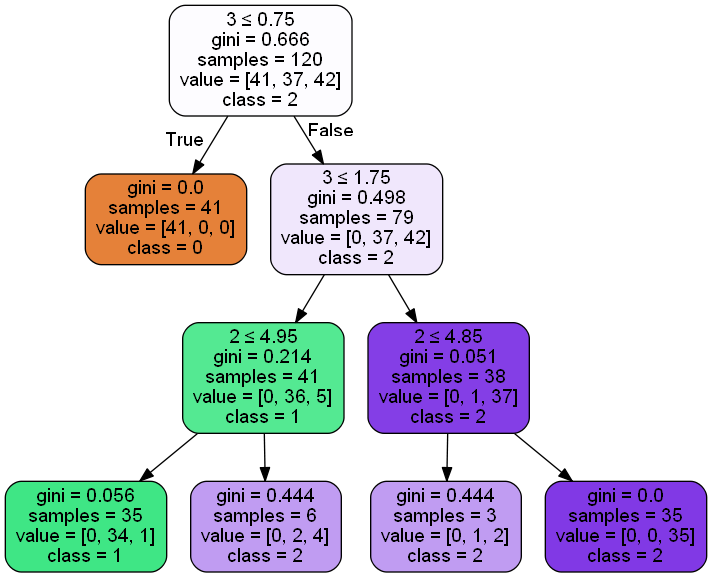

In [34]:
from sklearn.tree import export_graphviz
from io import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = [str(i) for i in range(4)],class_names=['0','1','2'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('diabetes2.png')
Image(graph.create_png())

In [35]:
n_samples, n_features = X.shape
feature=3
threshold=0.7
left_mask = X[:, feature] <= threshold
right_mask = ~left_mask
left_y=y[left_mask]
right_y=y[right_mask]
left_gini=gini_impurity(left_y)
right_gini=gini_impurity(right_y)
gini=(np.sum(left_mask)*left_gini+np.sum(right_mask)*right_gini)/n_samples
print(f"gini:{gini}")

gini:0.3278481012658228


In [37]:
n_samples, n_features = X.shape
feature=2
threshold=1.9
left_mask = X[:, feature] <= threshold
right_mask = ~left_mask
left_y=y[left_mask]
right_y=y[right_mask]
left_gini=gini_impurity(left_y)
right_gini=gini_impurity(right_y)
gini=(np.sum(left_mask)*left_gini+np.sum(right_mask)*right_gini)/n_samples
print(f"gini:{gini}")

gini:0.3278481012658228


In [37]:
X=X_train
y=y_train

n_samples, n_features = X.shape
feature=2
threshold=2.4
left_mask = X[:, feature] <= threshold
right_mask = ~left_mask
left_y=y[left_mask]
right_y=y[right_mask]
left_gini=gini_impurity(left_y)
right_gini=gini_impurity(right_y)
gini=(np.sum(left_mask)*left_gini+np.sum(right_mask)*right_gini)/n_samples
print(f"gini:{gini}")

gini:0.3278481012658228


In [38]:
#Use entropy

clf2 = DecisionTreeClassifier(criterion="entropy", max_depth=3)
# Train Decision Tree Classifer
clf2 = clf2.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf2.predict(X_test)
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 1.0


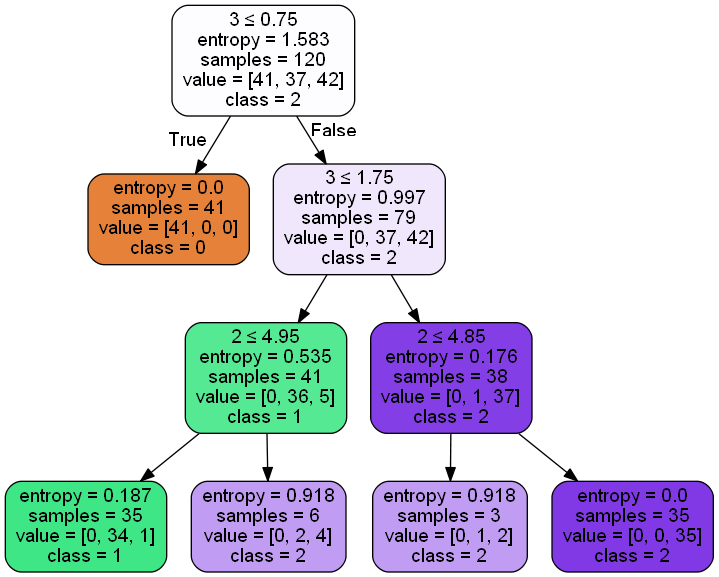

In [39]:
dot_data = StringIO()
export_graphviz(clf2, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = [str(i) for i in range(4)],class_names=['0','1','2'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('diabetes2.png')
Image(graph.create_png())